 # Radiomics model building using Auto ML
 Wookjin Choi <wookjin.choi@jefferson.edu>

 ## Import modules

In [1]:
import autosklearn
import autosklearn.classification
import sklearn.model_selection
import sklearn.datasets
import sklearn.metrics
from sklearn import datasets, cluster
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import GenericUnivariateSelect
from sklearn.feature_selection import RFE
from sklearn.feature_selection import RFECV
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import SelectFromModel
import pandas as pd
import numpy as np


 ## 1. Data loading

In [2]:
clinical_lidc72 = pd.read_csv("metadata/LIDC_72.csv")
clinical_lidc = pd.read_csv("metadata/LIDC.csv")
clinical_lungx = pd.read_csv("metadata/LUNGx.csv")

#features_lidc = pd.read_csv("output/feature-list_nodule-lidc_pylidc.csv")
features_lidc = pd.read_csv("output/feature-list_nodule-lidc.csv")
features_lungx = pd.read_csv("output/feature-list_nodule-lungx.csv")

lidc_tags = features_lidc.Tags.str.split("-").apply(pd.Series)
features_lidc['NID'] = lidc_tags[0].astype(int)
features_lidc['Tags'] = lidc_tags[1]

lungx_tags = features_lungx.Tags.str.split("-").apply(pd.Series)
lungx_tags.iloc[lungx_tags[2].isna(), 1] = "gc"
#lungx_tags.iloc[lungx_tags[2].isna(), 2] = "1mm"

features_lungx['NID'] = lungx_tags[0].astype(int)
features_lungx['Tags'] = lungx_tags[1]

features_lidc = features_lidc.loc[(features_lidc.Tags=='seg')]
features_lungx = features_lungx.loc[(features_lungx.Tags=='seg')]

#features_lidc = features_lidc.drop(columns=["WeightedElongation","WeightedFlatness","2DWeightedElongation","2DWeightedFlatness"])
#features_lungx = features_lungx.drop(columns=["WeightedElongation","WeightedFlatness","2DWeightedElongation","2DWeightedFlatness"])
features_lidc72 = features_lidc.loc[features_lidc.PID.isin(clinical_lidc72.PID) & (features_lidc.NID==1)]
features_lidc72RM = features_lidc.loc[features_lidc.PID.isin(clinical_lidc72.PID)]

clinical_lidc = clinical_lidc.loc[clinical_lidc.set_index(['PID','NID']).index.isin(features_lidc.set_index(['PID','NID']).index)]
features_lidc = features_lidc.loc[features_lidc.set_index(['PID','NID']).index.isin(clinical_lidc.set_index(['PID','NID']).index)]

features_lidc_train = features_lidc.loc[~features_lidc.PID.isin(clinical_lidc72.PID)]
clinical_lidc_train = clinical_lidc.loc[~clinical_lidc.PID.isin(clinical_lidc72.PID)]
clinical_lidc72RM = clinical_lidc.loc[clinical_lidc.PID.isin(clinical_lidc72.PID)]

In [3]:
spiculation_lidc = pd.read_csv("output/nodule-lidc/spiculation/features.csv")
spiculation_lungx = pd.read_csv("output/nodule-lungx/spiculation/features.csv")

spiculation_lidc72RM = spiculation_lidc.loc[spiculation_lidc.PID.isin(clinical_lidc72.PID)]
spiculation_lidc72 = spiculation_lidc.loc[spiculation_lidc.PID.isin(clinical_lidc72.PID) & (spiculation_lidc.NID==1)]

spiculation_lidc = spiculation_lidc.loc[spiculation_lidc.set_index(['PID','NID']).index.isin(clinical_lidc.set_index(['PID','NID']).index)]
spiculation_lidc_train = spiculation_lidc.loc[~spiculation_lidc.PID.isin(clinical_lidc72.PID)]

 ### 1.1 Data preprocessing

In [4]:
#X = features_lidc_train.iloc[:, 4:-1].update(spiculation_lungx.iloc[:,3:])
X = pd.concat([features_lidc_train.reset_index().iloc[:, 5:-1], spiculation_lidc_train.reset_index().iloc[:,4:]], axis=1) # with spiculation features
X = X.loc[:,X.isna().sum(axis=0)==0]
y = clinical_lidc_train.Malignancy > 3

#X_72RM = features_lidc72RM.iloc[:, 4:-1]
X_72RM = pd.concat([features_lidc72RM.reset_index().iloc[:, 5:-1], spiculation_lidc72RM.reset_index().iloc[:,4:]], axis=1) # with spiculation features
X_72RM = X_72RM.loc[:,X_72RM.isna().sum(axis=0)==0]
y_72RM = clinical_lidc72RM.Malignancy > 3

#X_72 = features_lidc72.iloc[:, 4:-1]
X_72 = pd.concat([features_lidc72.reset_index().iloc[:, 5:-1], spiculation_lidc72.reset_index().iloc[:,4:]], axis=1) # with spiculation features
X_72 = X_72.loc[:,X_72.isna().sum(axis=0)==0]
y_72 = clinical_lidc72.PMalignancy == 2

#X_lungx = features_lungx.iloc[:, 4:-1]
X_lungx = pd.concat([features_lungx.reset_index().iloc[:, 5:-1], spiculation_lungx.reset_index().iloc[:,4:]], axis=1) # with spiculation features
X_lungx = X_lungx.loc[:,X_lungx.isna().sum(axis=0)==0]
y_lungx = clinical_lungx.malignancy > 0

In [5]:
columns =  np.intersect1d(np.intersect1d(np.intersect1d(X.columns, X_72RM.columns), X_72.columns), X_lungx.columns)
X = X[columns]
X_72RM = X_72RM[columns]
X_72 = X_72[columns]
X_lungx = X_lungx[columns]

In [6]:
X_lungx_cal = X_lungx.iloc[0:10]
y_lungx_cal = y_lungx.iloc[0:10]
X_lungx_test = X_lungx.iloc[10:]
y_lungx_test = y_lungx.iloc[10:]

 ### 1.2 Data splitting

In [7]:
X_train, X_test, y_train, y_test = \
    sklearn.model_selection.train_test_split(X, y, test_size=0.2, random_state=42)

 ## 2. Feature Selection

 ### 2.1 Redundant Feature Elimination

In [8]:
agglo = cluster.FeatureAgglomeration(affinity='precomputed', linkage='complete', n_clusters=None, distance_threshold=0.3)
agglo.fit(1-abs(X_train.corr()))
cv_f = X_train.std()/X_train.mean().abs()

feature_groups = [np.array(X_train.columns[agglo.labels_==i]) for i in np.unique(agglo.labels_)]
feature_reps = [cv_f[f].sort_values().index[-1] for f in feature_groups]
feature_reps


['StandardDeviationOfLowGreyLevelRunEmphasis',
 'BoundingBoxSize3',
 'MeanOfLongRunHighGreyLevelEmphasis',
 'nh5',
 'spic1',
 'Skewness',
 'min_a',
 'min_w',
 'var_GC',
 'nh6',
 'nh10',
 'Roundness',
 'min_nw',
 'Kurtosis',
 'med_NArD',
 'num_spic',
 'med_GC',
 'nh9',
 'MeanOfLongRunLowGreyLevelEmphasis',
 'max_w',
 'WeightedPrincipalMoments1',
 'var_nw',
 'var_a',
 'Sum',
 'nh7',
 'spic2p',
 'min_MC',
 'BoundingBoxVolume',
 'kurt_MC',
 'StandardDeviationOfShortRunHighGreyLevelEmphasis',
 'WeightedPrincipalAxes4',
 'kurt_AnD',
 'MeanOfGreyLevelNonuniformity',
 'spic3',
 'var_MC',
 'med_ArD',
 '2DPrincipalAxes3',
 'nh2',
 'var_w',
 'num_lobul',
 'Variance',
 '2DMinimum',
 'nh8',
 'num_attached',
 'spic2',
 'var_nh',
 '2DWeightedPrincipalAxes3',
 'nh4',
 'WeightedPrincipalAxes9',
 '2DMaximum',
 'kurt_ArD',
 'var_NArD',
 '2DWeightedPrincipalAxes4',
 'WeightedPrincipalAxes6',
 'PrincipalAxes3',
 'mean_NArD',
 'PrincipalAxes4',
 'spic_b',
 'PrincipalAxes5',
 '2DWeightedPrincipalMoments1',
 

In [9]:
#X_reduced_tr = pd.DataFrame(agglo.transform(X_train))
#X_reduced_ts = pd.DataFrame(agglo.transform(X_test))
#X_reduced_tr.columns = feature_reps
#X_reduced_ts.columns = feature_reps

X_reduced_tr = X_train[feature_reps]
X_reduced_ts = X_test[feature_reps]

print(X_reduced_tr.shape, X_reduced_ts.shape)
feature_groups[0].shape


(2011, 96) (503, 96)


(4,)

In [10]:
X_train = X_reduced_tr
X_test = X_reduced_ts


 ### 2.2 Feature Selection

In [11]:
trans = GenericUnivariateSelect(score_func=lambda X, y: X.mean(axis=0), mode='percentile', param=50)
X_trans = trans.fit_transform(X_train, y_train)

mutual_information = mutual_info_classif(X_train, y_train) 
trans = GenericUnivariateSelect(score_func=mutual_info_classif, mode='k_best', param=30)
X_trans = trans.fit_transform(X_train, y_train)
columns_retained_Select = X_train.columns[trans.get_support()].values
columns_retained_Select


array(['StandardDeviationOfLowGreyLevelRunEmphasis', 'BoundingBoxSize3',
       'nh5', 'Roundness', 'min_nw', 'num_spic', 'med_GC',
       'MeanOfLongRunLowGreyLevelEmphasis', 'max_w',
       'WeightedPrincipalMoments1', 'var_a', 'Sum', 'BoundingBoxVolume',
       'kurt_AnD', 'MeanOfGreyLevelNonuniformity', 'spic3', 'nh2',
       'var_w', 'spic2', '2DMaximum', '2DWeightedPrincipalMoments1',
       'nh1', 'nh3', 'mean_GC', 'WeightedPrincipalMoments2', 'skew_GC',
       '2DWeightedPrincipalMoments2', 'StandardDeviationOfEntropy',
       'StandardDeviationOfLongRunEmphasis', 'h2'], dtype=object)

In [12]:
clf = DecisionTreeClassifier()
clf.fit(X, y)

trans = SelectFromModel(clf, threshold='median', max_features=30)
X_trans = trans.fit_transform(X, y)
columns_retained_FromMode = X.columns[trans.get_support()].values
columns_retained_FromMode


array(['2DEquivalentEllipsoidDiameter2', '2DSkewness',
       '2DWeightedPrincipalMoments1', 'BoundingBoxSize3',
       'MeanOfShortRunHighGreyLevelEmphasis',
       'MeanOfShortRunLowGreyLevelEmphasis', 'Perimeter',
       'PrincipalAxes3', 'PrincipalAxes5', 'StandardDeviationOfEntropy',
       'StandardDeviationOfLongRunHighGreyLevelEmphasis',
       'StandardDeviationOfShortRunEmphasis',
       'StandardDeviationOfShortRunHighGreyLevelEmphasis',
       'WeightedPrincipalAxes4', 'WeightedPrincipalAxes5',
       'WeightedPrincipalAxes8', 'attachment', 'max_ArD', 'mean_nh',
       'med_GC', 'med_NArD', 'med_w', 'min_AnD', 'min_NArD', 'min_h',
       'min_nw', 'nh3', 'spic2', 'spic4p', 'var_nh'], dtype=object)

In [13]:
clf = DecisionTreeClassifier()
trans = RFE(clf, n_features_to_select=30)
X_trans = trans.fit_transform(X_train, y_train)
columns_retained_RFE = X_train.columns[trans.get_support()].values
columns_retained_RFE


array(['MeanOfLongRunHighGreyLevelEmphasis', 'spic1', 'Skewness',
       'Roundness', 'min_nw', 'MeanOfLongRunLowGreyLevelEmphasis',
       'WeightedPrincipalMoments1', 'min_MC', 'BoundingBoxVolume',
       'kurt_MC', 'WeightedPrincipalAxes4',
       'MeanOfGreyLevelNonuniformity', '2DMinimum', 'nh8', 'var_nh',
       'WeightedPrincipalAxes6', '2DWeightedPrincipalMoments1',
       'attachment', 'StandardDeviationOfShortRunEmphasis',
       'PrincipalAxes8', 'PrincipalAxes9', 'WeightedPrincipalMoments2',
       'max_AnD', 'skew_GC', 'WeightedPrincipalAxes2', 'Orientation',
       'WeightedPrincipalAxes3', 'StandardDeviationOfEntropy',
       'WeightedPrincipalAxes5', 'StandardDeviationOfLongRunEmphasis'],
      dtype=object)

In [14]:
clf = DecisionTreeClassifier()
trans = RFECV(clf)
X_trans = trans.fit_transform(X_train, y_train)
columns_retained_RFECV = X_train.columns[trans.get_support()].values
columns_retained_RFECV


array(['MeanOfGreyLevelNonuniformity'], dtype=object)

In [15]:
columns_retained = columns_retained_RFE

 ## 3. AutoML

 ### 3.1 TPOT

In [16]:
from tpot import TPOTClassifier

# X_train, X_test, y_train, y_test = \
#    sklearn.model_selection.train_test_split(X, y, random_state=42)
    
pipeline_optimizer = TPOTClassifier(generations=5, population_size=300, cv=5,
                                    random_state=42, verbosity=2)
# pipeline_optimizer.fit(X_train, y_train)
# print(pipeline_optimizer.score(X_test, y_test))
pipeline_optimizer.fit(X_train[columns_retained], y_train)
#pipeline_optimizer.export('tpot_exported_pipeline.py')


/home/wxc151/.pyenv/versions/miniconda3-latest/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


Optimization Progress:   0%|          | 0/1800 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: 0.8861350814167377

Generation 2 - Current best internal CV score: 0.8861350814167377

Generation 3 - Current best internal CV score: 0.8871264027258249

Generation 4 - Current best internal CV score: 0.8891152179548906

Generation 5 - Current best internal CV score: 0.8891152179548906

Best pipeline: ExtraTreesClassifier(RFE(VarianceThreshold(input_matrix, threshold=0.0001), criterion=entropy, max_features=0.3, n_estimators=100, step=0.3), bootstrap=True, criterion=gini, max_features=1.0, min_samples_leaf=5, min_samples_split=11, n_estimators=100)


TPOTClassifier(generations=5, population_size=300, random_state=42, verbosity=2)

 #### 3.2.1 TPOT validation

In [17]:
print("Test AUC:", pipeline_optimizer.score(X_test[columns_retained], y_test))
print("72RM AUC:", pipeline_optimizer.score(X_72RM[columns_retained], y_72RM))
print("72 AUC:", pipeline_optimizer.score(X_72[columns_retained], y_72))
print("LUNGx AUC:", pipeline_optimizer.score(X_lungx_test[columns_retained], y_lungx_test))


Test AUC: 0.8707753479125249
72RM AUC: 0.9080459770114943
72 AUC: 0.75
LUNGx AUC: 0.7123287671232876


 ### 3.2 AutoSklearn

In [18]:
automl = autosklearn.classification.AutoSklearnClassifier(
    time_left_for_this_task = 8000,
    per_run_time_limit = 800,
    seed=42, 
    memory_limit=None,
    metric=autosklearn.metrics.roc_auc,
    resampling_strategy='cv',
    resampling_strategy_arguments=dict(folds=5),
)
automl.fit(X_train[columns_retained], y_train)

print(np.max(automl.cv_results_['mean_test_score']))


/home/wxc151/.pyenv/versions/miniconda3-latest/lib/python3.9/site-packages/autosklearn/metalearning/metalearning/meta_base.py:68: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.metafeatures = self.metafeatures.append(metafeatures)
/home/wxc151/.pyenv/versions/miniconda3-latest/lib/python3.9/site-packages/autosklearn/metalearning/metalearning/meta_base.py:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.algorithm_runs[metric].append(runs)


0.8577583600980586


 #### 3.2.1 AutoSklearn validation

In [19]:
#predict
y_hat = automl.predict(X_test[columns_retained])
y_pred = automl.predict_proba(X_test[columns_retained])

y_hat_72RM = automl.predict(X_72RM[columns_retained])
y_pred_72RM = automl.predict_proba(X_72RM[columns_retained])

y_hat_72 = automl.predict(X_72[columns_retained])
y_pred_72 = automl.predict_proba(X_72[columns_retained])

y_hat_lungx = automl.predict(X_lungx_test[columns_retained])
y_pred_lungx = automl.predict_proba(X_lungx_test[columns_retained])

# show scores
print("Test AUC: ", sklearn.metrics.roc_auc_score(y_test, y_pred[:,1]))
print("72RM AUC: ", sklearn.metrics.roc_auc_score(y_72RM, y_pred_72RM[:,1]))
print("72 AUC: ", sklearn.metrics.roc_auc_score(y_72, y_pred_72[:,1]))
print("LUNGx AUC: ", sklearn.metrics.roc_auc_score(y_lungx_test, y_pred_lungx[:,1]))

print("\nTest Accuracy: ", sklearn.metrics.accuracy_score(y_test, y_hat))
print("72RM Accuracy: ", sklearn.metrics.accuracy_score(y_72RM, y_hat_72RM))
print("72 Accuracy: ", sklearn.metrics.accuracy_score(y_72, y_hat_72))
print("LUNGx Accuracy: ", sklearn.metrics.accuracy_score(y_lungx_test, y_hat_lungx))


Test AUC:  0.8754144562334218
72RM AUC:  0.9453844865136539
72 AUC:  0.7930763178599527
LUNGx AUC:  0.7222222222222222

Test Accuracy:  0.827037773359841
72RM Accuracy:  0.7298850574712644
72 Accuracy:  0.4305555555555556
LUNGx Accuracy:  0.5068493150684932


 #### 3.2.2 AutoSklearn models

In [20]:
# show all models
show_models_str=automl.show_models()
sprint_statistics_str = automl.sprint_statistics()
leaderboard = automl.leaderboard()

print(sprint_statistics_str)
print(leaderboard)

auto-sklearn results:
  Dataset name: fb1a7d99-ead2-11ec-83f4-3cecef05586a
  Metric: roc_auc
  Best validation score: 0.857758
  Number of target algorithm runs: 377
  Number of successful target algorithm runs: 368
  Number of crashed target algorithm runs: 7
  Number of target algorithms that exceeded the time limit: 2
  Number of target algorithms that exceeded the memory limit: 0

          rank  ensemble_weight           type      cost   duration
model_id                                                           
310          1             0.02            qda  0.142242   2.863319
322          2             0.02            qda  0.143328   2.872027
276          3             0.04            qda  0.143813   2.841773
200          4             0.02  random_forest  0.143837  10.867415
177          5             0.06  liblinear_svc  0.144039   5.412967
312          6             0.08            qda  0.145972   2.668356
358          7             0.02  random_forest  0.147158  10.603116


In [21]:
print(show_models_str[leaderboard.index[0]])

{'model_id': 310, 'rank': 1, 'cost': 0.1422416399019414, 'ensemble_weight': 0.02, 'voting_model': VotingClassifier(estimators=None, voting='soft'), 'estimators': [{'data_preprocessor': <autosklearn.pipeline.components.data_preprocessing.DataPreprocessorChoice object at 0x7ff3b05b9d00>, 'balancing': Balancing(random_state=42, strategy='weighting'), 'feature_preprocessor': <autosklearn.pipeline.components.feature_preprocessing.FeaturePreprocessorChoice object at 0x7ff3b0564c40>, 'classifier': <autosklearn.pipeline.components.classification.ClassifierChoice object at 0x7ff3b0590910>, 'sklearn_classifier': QuadraticDiscriminantAnalysis(reg_param=0.48728362945857834)}, {'data_preprocessor': <autosklearn.pipeline.components.data_preprocessing.DataPreprocessorChoice object at 0x7ff61105df40>, 'balancing': Balancing(random_state=42, strategy='weighting'), 'feature_preprocessor': <autosklearn.pipeline.components.feature_preprocessing.FeaturePreprocessorChoice object at 0x7ff610f55af0>, 'classif

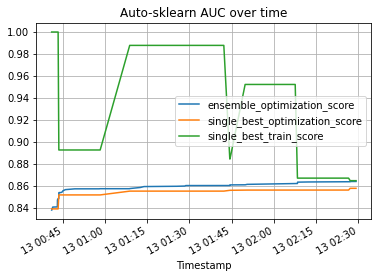

In [22]:
import matplotlib.pyplot as plt

poT = automl.performance_over_time_
poT.plot(
    x='Timestamp',
    kind='line',
    legend=True,
    title='Auto-sklearn AUC over time',
    grid=True,
)
plt.show()


In [23]:
def get_metric_result(cv_results):
    results = pd.DataFrame.from_dict(cv_results)
    results = results[results['status'] == "Success"]
    cols = ['rank_test_scores', 'param_classifier:__choice__', 'mean_test_score']
    cols.extend([key for key in cv_results.keys() if key.startswith('metric_')])
    return results[cols]

print("Metric results")
print(get_metric_result(automl.cv_results_).to_string(index=False))


Metric results
 rank_test_scores param_classifier:__choice__  mean_test_score
              150               random_forest         0.839035
              211                    adaboost         0.822398
              228           gradient_boosting         0.815675
              202                    adaboost         0.824655
              246                         qda         0.803470
              154               random_forest         0.838153
              242           gradient_boosting         0.806520
               32                 extra_trees         0.851756
              225                         sgd         0.816498
               71               random_forest         0.847615
              229                 extra_trees         0.814898
              181                         qda         0.831648
              152               random_forest         0.838289
              200           gradient_boosting         0.825738
              116           gradient_boo